# Ingredient Recognition - Fine-tuning Vision Transformers

This notebook focuses on fine-tuning pre-trained Vision Transformers on the Food-101 dataset using Ingredients-101 labels. The goal is to train a model capable of recognizing ingredients in an image. For this purpose, multiple Vision Transformer models will be tested and evaluated.

## Set up the Environment

### Import required libraries

In [1]:
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
import warnings
warnings.filterwarnings("ignore")
import wandb
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as T
from pathlib import Path
from PIL import Image
import datasets
import os
import json
import jsonlines
from timm import create_model
from transformers.optimization import get_cosine_schedule_with_warmup
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import random
import time
from tqdm import tqdm
import wandb
import torch
from torch.optim import AdamW
import numpy as np
from tqdm import tqdm

from torchvision import transforms as T
import random
from PIL import Image
from sklearn.metrics import multilabel_confusion_matrix

from prettytable import PrettyTable

d:\MA\food-datasets\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading

In [2]:
# annotations_path = Path("../data/ingredients-101/Annotations/")
# images_path = Path("../data/food-101/images/")
# ingredients_path = 'ingredients_simplified.txt'
# simplifications_path = Path("../data/ingredients-101/ingredients_simplification/")

In [3]:
# def read_data(path, file):
#     with open(path / file, 'r') as f:
#         data = f.read().strip().split('\n')
#     return data

In [4]:
# train_images = read_data(annotations_path, 'train_images.txt')
# val_images = read_data(annotations_path, 'val_images.txt')
# test_images = read_data(annotations_path, 'test_images.txt')

# train_labels = read_data(annotations_path, 'train_labels.txt')
# val_labels = read_data(annotations_path, 'val_labels.txt')
# test_labels = read_data(annotations_path, 'test_labels.txt')

# base_ingredients = read_data(simplifications_path, 'baseIngredients.txt')
# ingredients_simplified = read_data(annotations_path, ingredients_path)

### Preprocess the data

In [5]:
# chilli is always spelled correctly in dataset
# pepper and black pepper are not the same
# baking most probably refers to baking powder, because it appears in relation to swwet cake like recipes (eg carrot cake or cup cake)
# there are 3 types of sugar: sugar, brown sugar, caster sugar


# change 'baking' to 'baking powder' in ingredients_simplified
# ingredients_simplified = [line.replace('baking', 'baking powder') for line in ingredients_simplified]


### Convert Ingredients List to Multi-label Format

In [6]:
# ingredients_simplified[:3]

In [7]:
# corrected_ingredients_simplified = [ingredient.strip() for sublist in ingredients_simplified for ingredient in sublist.split(',')]
# corrected_ingredients_simplified[:10]

In [8]:
# # get only the unique ingredients
# unique_ingredients = list(set(corrected_ingredients_simplified))
# num_unique_ingredients = len(unique_ingredients)
# num_unique_ingredients

In [9]:
# # sort the ingredients alphabetically
# unique_ingredients.sort()

# # create a dictionary with the ingredients as keys and the index as values
# ingredient_to_idx = {ingredient: idx for idx, ingredient in enumerate(unique_ingredients)}
# idx_to_ingredient = {idx: ingredient for ingredient, idx in ingredient_to_idx.items()}

# # create the directory if it does not exist
# os.makedirs('../data/food-ingredients', exist_ok=True)

# # save to a file
# with open('../data/food-ingredients/ingredient_to_idx.txt', 'w') as f:
#     for key, value in ingredient_to_idx.items():
#         f.write(f'{key}, {value}\n')

In [10]:
# numerical_ingredients_simplified = [[ingredient_to_idx[ingredient.strip()] for ingredient in sublist.split(',')] for sublist in ingredients_simplified]

# numerical_ingredients_simplified[:5]

In [11]:
# # manually check the correctness of the conversion
# print(idx_to_ingredient[183])

# print([idx_to_ingredient[idx] for idx in numerical_ingredients_simplified[1]]) 

In [12]:
# # Create a dictionary to map each class to its ingredients
# class_to_ingredients = {i: ingredients for i, ingredients in enumerate(ingredients_simplified)}
# class_to_ingredients

# # save to a file
# with open('../data/food-ingredients/class_to_ingredients.jsonl', 'w') as f:
#     for key, value in class_to_ingredients.items():
#         f.write(json.dumps({key: value}) + '\n')

### Create Dataset

In [13]:
# # create a jsonl file with the data

# with jsonlines.open('../data/food-ingredients/train.jsonl', 'w') as writer:
#     for image, label in zip(train_images, train_labels):
#         ingredients = class_to_ingredients[int(label)]
#         ingredients_numeric = [ingredient_to_idx[ingredient] for ingredient in ingredients.split(',')]
#         writer.write({'image': str(images_path) + '/' + image + '.jpg', 'ingredients': ingredients_numeric, 'ingredients_names': ingredients.split(','), 'class': int(label), 'class_name': image.split('/')[0]})

# with jsonlines.open('../data/food-ingredients/val.jsonl', 'w') as writer:
#     for image, label in zip(val_images, val_labels):
#         ingredients = class_to_ingredients[int(label)]
#         ingredients_numeric = [ingredient_to_idx[ingredient] for ingredient in ingredients.split(',')]
#         writer.write({'image': str(images_path) + '/' + image + '.jpg', 'ingredients': ingredients_numeric, 'ingredients_names': ingredients.split(','), 'class': int(label), 'class_name': image.split('/')[0]})

# with jsonlines.open('../data/food-ingredients/test.jsonl', 'w') as writer:
#     for image, label in zip(test_images, test_labels):
#         ingredients = class_to_ingredients[int(label)]
#         ingredients_numeric = [ingredient_to_idx[ingredient] for ingredient in ingredients.split(',')]
#         writer.write({'image': str(images_path) + '/' + image + '.jpg', 'ingredients': ingredients_numeric, 'ingredients_names': ingredients.split(','), 'class': int(label), 'class_name': image.split('/')[0]})

## Prepare to tune the model

### Load the data

In [14]:
# load dataset
data_files = {"train": "../data/food-ingredients/train.jsonl", "val": "../data/food-ingredients/val.jsonl", "test": "../data/food-ingredients/test.jsonl"}

dataset = datasets.load_dataset('json', data_files=data_files)

In [16]:
def read_data(path, file):
    with open(path / file, 'r') as f:
        data = f.read().strip().split('\n')
    return data

In [17]:
annotations_path = Path("../data/ingredients-101/Annotations/")
ingredients_path = 'ingredients_simplified.txt'

ingredients_simplified = read_data(annotations_path, ingredients_path)
ingredients_simplified_prep = [ingredient.strip() for sublist in ingredients_simplified for ingredient in sublist.split(',')]

unique_ingredients = list(set(ingredients_simplified_prep))
num_unique_ingredients = len(unique_ingredients)
num_unique_ingredients

227

### Vizualize the data

In [18]:
# def show_samples(ds,rows,cols):
#     # selecting random images with randomstate
#     samples = ds.shuffle(seed=20).select(range(rows*cols))
#     fig = plt.figure(figsize=(cols*4,rows*4))
#     # plotting
#     for i in range(rows*cols):
#         img = samples[i]['image']
#         # add full path and open image
#         img = Image.open(img)

#         labels = samples[i]['ingredients']
#         # getting string labels and combining them with a comma
#         labels = ','.join([idx_to_ingredient[lb] for lb in labels])
#         fig.add_subplot(rows,cols,i+1)
#         plt.imshow(img)
#         plt.title(labels)
#         plt.axis('off')
            
# show_samples(dataset['train'],rows=2,cols=2)

### Perform transformations

To identify a suitable augmentation method, four different strategies are implemented:

- No augmentation
- Simple augmentation
- Han Augmentation [1]
- Gao Augmentation [2]

In [ ]:
img_size = (224, 224)
AUGMENTATION = 'han'

# no augmentation
if AUGMENTATION == 'no':
    tfms_no_aug = T.Compose([
        T.Resize(img_size),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# simple augmentation
if AUGMENTATION == 'simple':
    tfms_simple_aug = T.Compose([
        T.Resize(img_size),
        T.RandomHorizontalFlip(),
        T.RandomRotation(30),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# Han augmentation
if AUGMENTATION == 'han':
    tfms_han_aug = T.Compose([
        T.Resize(img_size),
        T.RandomResizedCrop(img_size, scale=(0.08, 1.0)),
        T.RandomRotation(degrees=10),
        T.RandomAffine(degrees=0, scale=(1.0, 1.1)),  # Dies ist für den Zoom-Effekt
        T.RandomPerspective(distortion_scale=0.2, p=0.5),
        T.ColorJitter(brightness=0.3, contrast=0.3),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# Gao augmentation
class GaussianBlur(object):
    def __init__(self, kernel_size, sigma=(0.1, 2.0)):
        self.kernel_size = kernel_size
        self.sigma = sigma

    def __call__(self, img):
        return T.functional.gaussian_blur(img, self.kernel_size, random.uniform(*self.sigma))

class Solarization(object):
    def __init__(self, threshold=128):
        self.threshold = threshold

    def __call__(self, img):
        return T.functional.solarize(img, self.threshold)

if AUGMENTATION == 'gao':
    tfms_gao_aug = T.Compose([
        T.RandomResizedCrop(size=224, scale=(0.08, 1.0)),
        T.RandomHorizontalFlip(p=0.5),
        T.TrivialAugmentWide(),
        GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        T.RandomGrayscale(p=0.2),
        Solarization(threshold=128),
        T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        T.ToTensor(),  # Convert to tensor before RandomErasing
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random'),
    ])

valid_tfms = T.Compose([
    T.Resize(img_size),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [22]:
# function to apply transformations to the training data batch
# It opens images, augmentation, converts ingredients to one-hot encoded labels
def transforms(batch):
    batch['image'] = [Image.open(x).convert('RGB') for x in batch['image']]
    inputs = [tfms_han_aug(x) for x in batch['image']]
    batch['pixel_values'] = inputs

    labels = torch.zeros((len(batch['ingredients']), num_unique_ingredients))

    for i, ingredient_indices in enumerate(batch['ingredients']):
        labels[i, ingredient_indices] = 1

    batch['labels'] = labels

    return batch

# function to apply transformations to the validation data batch
def transforms_valid(batch):
    batch['image'] = [Image.open(x).convert('RGB') for x in batch['image']]
    inputs = [valid_tfms(x) for x in batch['image']]
    batch['pixel_values'] = inputs

    labels = torch.zeros((len(batch['ingredients']), num_unique_ingredients))

    for i, ingredient_indices in enumerate(batch['ingredients']):
        labels[i, ingredient_indices] = 1

    batch['labels'] = labels

    return batch

In [23]:
# apply transformations to the dataset
train_dataset = dataset['train'].with_transform(transforms)
valid_dataset = dataset['val'].with_transform(transforms_valid)
test_dataset = dataset['test'].with_transform(transforms_valid)

# check the length of the datasets
len(train_dataset), len(valid_dataset), len(test_dataset)

(68175, 7575, 25250)

In [24]:
# TODO: check if this is needed
# # for Han Augmentation
# train_dataset = dataset['train'].with_transform(lambda example: {
#     'pixel_values': tfms(Image.open(example['image']).convert('RGB')),
#     'labels': example['labels']  # oder was auch immer Ihr Label-Feld ist
# })
# valid_dataset = dataset['val'].with_transform(valid_tfms)
# test_dataset = dataset['test'].with_transform(valid_tfms)

# len(train_dataset), len(valid_dataset), len(test_dataset)

In [25]:
# Custom collate function that stacks 'pixel_values' and 'labels' from each sample into tensors
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.stack([x['labels'] for x in batch]).float()
    }

In [27]:
# create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# check size of the data
len(train_loader), len(valid_loader), len(test_loader)

In [26]:
# # uncomment for testing with less data

# # Anzahl der zu verwendenden Samples festlegen
# from sklearn.model_selection import train_test_split
# from torch.utils.data import Subset


# subset_size = 0.1  # Nutze 10% der Daten
# train_indices, _ = train_test_split(range(len(train_dataset)), train_size=subset_size, random_state=42)
# valid_indices, _ = train_test_split(range(len(valid_dataset)), train_size=subset_size, random_state=42)
# test_indices, _ = train_test_split(range(len(test_dataset)), train_size=subset_size, random_state=42)

# # Erstellen der Subsets
# train_subset = Subset(train_dataset, train_indices)
# valid_subset = Subset(valid_dataset, valid_indices)
# test_subset = Subset(test_dataset, test_indices)

# # Erstellen der DataLoader
# train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=collate_fn)
# valid_loader = DataLoader(valid_subset, batch_size=32, shuffle=False, collate_fn=collate_fn)
# test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, collate_fn=collate_fn)

## Tune the model

### Define evaluation functions

In [30]:
def multi_label_f1(y_true, y_pred, threshold=0.25, average='weighted', labels=None, pos_label=1, sample_weight=None):
    y_pred = (y_pred > threshold).astype(int)
    return f1_score(y_true, y_pred, average=average, labels=labels, pos_label=pos_label, sample_weight=sample_weight, zero_division=0.0)

def multi_label_accuracy(y_true, y_pred, threshold=0.25):
    y_pred = (y_pred > threshold).astype(int)
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = y_true.size
    accuracy = correct_predictions / total_predictions
    return accuracy

def multi_label_accuracy_samples(y_true, y_pred, threshold=0.25):
    y_pred = (y_pred > threshold).astype(int)
    sample_accuracies = [accuracy_score(y_true[i], y_pred[i]) for i in range(len(y_true))]
    return sum(sample_accuracies) / len(sample_accuracies)

def multi_label_recall(y_true, y_pred, threshold=0.25, average='weighted', labels=None, pos_label=1, sample_weight=None):
    y_pred = (y_pred > threshold).astype(int)
    return recall_score(y_true, y_pred, average=average, labels=labels, pos_label=pos_label, sample_weight=sample_weight, zero_division=0.0)

def multi_label_precision(y_true, y_pred, threshold=0.25, average='weighted', labels=None, pos_label=1, sample_weight=None):
    y_pred = (y_pred > threshold).astype(int)
    return precision_score(y_true, y_pred, average=average, labels=labels, pos_label=pos_label, sample_weight=sample_weight, zero_division=0.0)

def evaluate_model(actuals, predictions):
    accuracy = multi_label_accuracy(actuals, predictions)
    accuracy_samples = multi_label_accuracy_samples(actuals, predictions)
    recall_weighted = multi_label_recall(actuals, predictions, average='weighted')
    recall_samples = multi_label_recall(actuals, predictions, average='samples')
    precision_weighted = multi_label_precision(actuals, predictions, average='weighted')
    precision_samples = multi_label_precision(actuals, predictions, average='samples')
    f1_micro = multi_label_f1(actuals, predictions, average='micro')
    f1_samples = multi_label_f1(actuals, predictions, average='samples')
    f1_macro = multi_label_f1(actuals, predictions, average='macro')
    f1_weighted = multi_label_f1(actuals, predictions, average='weighted')
    return accuracy, accuracy_samples, recall_weighted, recall_samples, precision_weighted, precision_samples, f1_micro, f1_samples, f1_macro, f1_weighted


### Optimize the learning rate

To determine the most suitable learning rate, a function is implemented that gradually increases the learning rate while logging the loss. The function uses an exponential increase in learning rate over a specified number of iterations, allowing observation of how the model's loss responds to different learning rates. 

In [31]:
os.environ["WANDB_DISABLE_SYMLINKS"] = "1"

def train_with_lr_test(model_name, batch_size=32, min_lr=1e-7, max_lr=1, num_iterations=100):

    # initialize wandb for experiment tracking
    wandb.init(project="finetuning-vit", config={
        "model_name": model_name,
        "batch_size": batch_size,
        "min_lr": min_lr,
        "max_lr": max_lr,
        "num_iterations": num_iterations,
    })
    wandb.run.name = f"{model_name}-lr-test"
    
    # set up device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Using {device}')

    model = create_model(model_name, num_classes=num_unique_ingredients, pretrained=True)
    model.to(device)

    # define optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=min_lr)
    loss_fn = nn.BCEWithLogitsLoss()
    
    # define a function to calculate learning rate for each iteration
    lr_lambda = lambda x: np.exp(x * np.log(max_lr / min_lr) / num_iterations)
    
    model.train()
    iteration = 0
    pbar = tqdm(total=num_iterations, desc="LR Test Progress")
    
    while iteration < num_iterations:
        for batch in train_loader:
            if iteration >= num_iterations:
                break
            
            inputs = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            
            optimizer.zero_grad()
            logits = model(inputs)
            loss = loss_fn(logits, labels)
            loss.backward()
            
            # Update learning rate
            for param_group in optimizer.param_groups:
                param_group['lr'] = min_lr * lr_lambda(iteration)
            
            # Update model parameters
            optimizer.step()

            # Log loss and learning rate
            current_lr = optimizer.param_groups[0]['lr']
            wandb.log({"loss": loss.item(), "learning_rate": current_lr, "iteration": iteration})

            iteration += 1
            pbar.update(1)

    pbar.close()
    wandb.finish()

# Uncomment to run the learning rate test
# train_with_lr_test("deit3_medium_patch16_224", min_lr=1e-7, max_lr=1e-1, num_iterations=500)

wandb: Currently logged in as: ahirsch (htwbe). Use `wandb login --relogin` to force relogin


Using cuda:0


LR Test Progress:   0%|          | 0/500 [00:00<?, ?it/s]d:\MA\food-datasets\.venv\Lib\site-packages\timm\models\vision_transformer.py:91: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  x = F.scaled_dot_product_attention(
LR Test Progress: 100%|██████████| 500/500 [07:11<00:00,  1.16it/s]


iteration,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▄▅▆█
loss,████████▇▇▇▆▅▃▃▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▄▂▁▁▁▁
iteration,499
learning_rate,0.09727
loss,0.12196


### Train the model with frozen layers

In [ ]:
# def train(model_name, batch_size=8, epochs=1, lr=2e-4, unfreeze_last_n=4, freeze_epochs=3):
#     os.environ["WANDB_DISABLE_SYMLINKS"] = "1"
#     wandb.init(project="vit-freezing-augumentation", config={
#         "model_name": model_name,
#         "batch_size": batch_size,
#         "epochs": epochs,
#         "learning_rate": lr,
#         "unfreeze_last_n": unfreeze_last_n,
#         "freeze_epochs": freeze_epochs
#     })

#     config = wandb.config
    
#     device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#     print(f'Using {device}')

#     print("Loading the model...")
#     model = create_model(model_name, num_classes=num_unique_ingredients)
#     print(num_unique_ingredients)
#     model.to(device)
#     print("Model loaded.")

#     def freeze_layers(freeze=True):
#         if freeze:
#             # Freeze all layers initially
#             for param in model.parameters():
#                 param.requires_grad = False

#             # Unfreeze the last 'unfreeze_last_n' layers
#             if 'volo' in model_name:
#                 trainable_params = list(model.named_parameters())[-unfreeze_last_n:]
#                 for name, param in trainable_params:
#                     param.requires_grad = True
#             elif 'swin' in model_name:
#                 layers = list(model.layers)
#                 for layer in layers[-unfreeze_last_n:]:
#                     for param in layer.parameters():
#                         param.requires_grad = True
#             elif 'deit' in model_name:
#                 if hasattr(model, 'blocks'):
#                     blocks = list(model.blocks)
#                     for block in blocks[-unfreeze_last_n:]:
#                         for param in block.parameters():
#                             param.requires_grad = True
#                 else:
#                     print("Warning: Unable to identify blocks in DeiT model. Unfreezing last layers based on parameter count.")
#                     trainable_params = list(model.parameters())[-unfreeze_last_n * 100:]  # Approximation
#                     for param in trainable_params:
#                         param.requires_grad = True
#             else:
#                 trainable_params = list(model.parameters())[-unfreeze_last_n * 100:]  # Approximation
#                 for param in trainable_params:
#                     param.requires_grad = True

#             print(f"Froze all layers except approximately the last {unfreeze_last_n} layers of the model.")
#         else:
#             # Unfreeze all layers
#             for param in model.parameters():
#                 param.requires_grad = True
#             print("Unfroze all layers of the model.")

#     # Initially freeze layers
#     freeze_layers(freeze=True)

#     loss_fn = nn.BCEWithLogitsLoss()

#     for epoch in range(epochs):
#         # Unfreeze all layers after freeze_epochs
#         if epoch == freeze_epochs:
#             freeze_layers(freeze=False)
#             print("Unfreezing all layers and reinitializing optimizer")
#             optimizer = optim.AdamW(model.parameters(), lr=lr)
#             scheduler = get_cosine_schedule_with_warmup(
#                 optimizer,
#                 num_warmup_steps=int(0.1 * len(train_loader)),
#                 num_training_steps=len(train_loader) * (epochs - freeze_epochs)
#             )
#         elif epoch == 0:
#             # Initial optimizer setup
#             optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
#             scheduler = get_cosine_schedule_with_warmup(
#                 optimizer,
#                 num_warmup_steps=int(0.1 * len(train_loader)),
#                 num_training_steps=len(train_loader) * epochs
#             )

#         ## Training
#         model.train()
#         train_metric = evaluate.load('roc_auc', 'multilabel')
#         running_loss = 0.0
#         predictions, actuals = [], []

#         print(f"\nStarting training epoch {epoch}...")

#         for batch in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
#             inputs = batch['pixel_values'].to(device)
#             logits = model(inputs)
#             labels = batch['labels'].to(device) 

#             loss = loss_fn(logits, labels)
#             loss.backward()
#             optimizer.step()
#             scheduler.step()
#             optimizer.zero_grad()

#             running_loss += loss.item()
#             train_metric.add_batch(references=labels.cpu(), prediction_scores=logits.cpu())
            
#             predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
#             actuals.append(labels.cpu().numpy())

#         predictions = np.vstack(predictions)
#         actuals = np.vstack(actuals)

#         print("Unique values in labels:", np.unique(actuals))
#         is_binary = np.all(np.isin(actuals, [0, 1]))
#         print("Data is binary:", is_binary)
        
        
#         train_loss = running_loss / len(train_loader)
#         train_roc_auc = train_metric.compute(average='micro')['roc_auc']
#         train_f1_micro = multi_label_f1_micro(actuals, predictions)
#         train_f1_macro = multi_label_f1_macro(actuals, predictions)
#         train_f1_weighted = multi_label_f1_weighted(actuals, predictions)
#         train_f1_samples = multi_label_f1_samples(actuals, predictions)
#         train_accuracy = multi_label_accuracy(actuals, predictions)
#         train_recall = multi_label_recall(actuals, predictions)
#         train_precision = multi_label_precision(actuals, predictions)

#         print(f"{train_loss = :.3f} | {train_f1_samples = :.3f}")
        
#         wandb.log({"train_loss": train_loss, "train_roc_auc": train_roc_auc, "epoch": epoch, "train_f1_micro": train_f1_micro, "train_f1_macro": train_f1_macro, "train_f1_weighted": train_f1_weighted, "train_f1_samples": train_f1_samples, "train_accuracy": train_accuracy, "train_recall": train_recall, "train_precision": train_precision})
        
#         ## Validation

#         model.eval()
#         running_loss = 0.0
#         valid_metric = evaluate.load('roc_auc', 'multilabel')
        
#         print(f"Starting validation epoch {epoch}...")
#         val_start_time = time.time()

#         predictions, actuals = [], []
        
#         for batch in tqdm(valid_loader, desc=f"Validation Epoch {epoch}"):
#             with torch.no_grad():
#                 inputs = batch['pixel_values'].to(device)
#                 logits = model(inputs)
#                 labels = batch['labels'].to(device) 
#             loss = loss_fn(logits, labels)
#             running_loss += loss.item()
#             valid_metric.add_batch(references=labels.cpu(), prediction_scores=logits.cpu())

#             predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
#             actuals.append(labels.cpu().numpy())

#         predictions = np.vstack(predictions)
#         actuals = np.vstack(actuals)
        
#         val_end_time = time.time()
#         print(f"Completed validation epoch {epoch} in {val_end_time - val_start_time:.2f} seconds")
        
#         valid_loss = running_loss / len(valid_loader)
#         valid_roc_auc = valid_metric.compute(average='micro')['roc_auc']
#         valid_f1_micro = multi_label_f1_micro(actuals, predictions)
#         valid_f1_macro = multi_label_f1_macro(actuals, predictions)
#         valid_f1_weighted = multi_label_f1_weighted(actuals, predictions)
#         valid_f1_samples = multi_label_f1_samples(actuals, predictions)
#         valid_accuracy = multi_label_accuracy(actuals, predictions)
#         valid_recall = multi_label_recall(actuals, predictions)
#         valid_precision = multi_label_precision(actuals, predictions)

        
#         print(f"{valid_loss = :.3f} | {valid_f1_samples = :.3f}")
        
#         wandb.log({"valid_loss": valid_loss, "valid_roc_auc": valid_roc_auc, "epoch": epoch, "valid_f1_micro": valid_f1_micro, "valid_f1_macro": valid_f1_macro, "valid_f1_weighted": valid_f1_weighted, "valid_f1_samples": valid_f1_samples, "valid_accuracy": valid_accuracy, "valid_recall": valid_recall, "valid_precision": valid_precision})
        
#         model_path = f'./models/{model_name}-pascal-epoch-{epoch}.pth'
#         torch.save(model.state_dict(), model_path)


#     ## Testing
    
#     test_metric = evaluate.load('roc_auc', 'multilabel')
    
#     print(f"Starting test evaluation...")
#     test_start_time = time.time()

#     predictions, actuals = [], []

#     for batch in tqdm(test_loader, desc="Testing"):
#         with torch.no_grad():
#             inputs = batch['pixel_values'].to(device)
#             logits = model(inputs)
#             labels = batch['labels'].to(device)
#         test_metric.add_batch(references=labels.cpu(), prediction_scores=logits.cpu())

#         predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
#         actuals.append(labels.cpu().numpy())

#     predictions = np.vstack(predictions)
#     actuals = np.vstack(actuals)
    
#     test_end_time = time.time()
#     print(f"Completed test evaluation in {test_end_time - test_start_time:.2f} seconds")
    
#     test_roc_auc = test_metric.compute(average='micro')['roc_auc']
#     test_f1_micro = multi_label_f1_micro(actuals, predictions)
#     test_f1_macro = multi_label_f1_macro(actuals, predictions)
#     test_f1_weighted = multi_label_f1_weighted(actuals, predictions)
#     test_f1_samples = multi_label_f1_samples(actuals, predictions)
#     test_accuracy = multi_label_accuracy(actuals, predictions)
#     test_recall = multi_label_recall(actuals, predictions)
#     test_precision = multi_label_precision(actuals, predictions)
    
#     wandb.log({"test_roc_auc": test_roc_auc, "test_f1_micro": test_f1_micro, "test_f1_macro": test_f1_macro, "test_f1_weighted": test_f1_weighted, "test_f1_samples": test_f1_samples, "test_accuracy": test_accuracy, "test_recall": test_recall, "test_precision": test_precision})

#     wandb.finish()

#     return model

# # Usage
# model_name = 'vit_base_patch16_224'
# model = train(model_name, batch_size=32, epochs=15, lr=2e-4, unfreeze_last_n=1, freeze_epochs=0)

In [ ]:
# copy of train method with additional freezing and unfreezing

def train(model_name, batch_size=8, epochs=1, lr=2e-4, augmentation=False, scheduler='none', unfreeze_last_n=4, freeze_epochs=3):
    os.environ["WANDB_DISABLE_SYMLINKS"] = "1"
    wandb.init(project="finetuning-vit", config={
        "model_name": model_name,
        "batch_size": batch_size,
        "epochs": epochs,
        "learning_rate": lr,
        "augmentation": augmentation,
        "scheduler": scheduler,
        "unfreeze_last_n": unfreeze_last_n,
        "freeze_epochs": freeze_epochs
    })
    wandb.run.name = f"{model_name}-lr-{lr}-augmented-{augmentation}-scheduler-{scheduler}"
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Using {device}')

    print("Loading the model...")
    model = create_model(model_name, num_classes=num_unique_ingredients, pretrained=True)
    print(f"The model has {num_unique_ingredients} output units.")
    model.to(device)
    print("Model loaded.")

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * len(train_loader)),
        num_training_steps=len(train_loader) * epochs
    )

    
    def freeze_layers(freeze=True):
        if freeze:
            # Freeze all layers initially
            for param in model.parameters():
                param.requires_grad = False

            # Unfreeze the last 'unfreeze_last_n' layers
            if 'volo' in model_name:
                trainable_params = list(model.named_parameters())[-unfreeze_last_n:]
                for name, param in trainable_params:
                    param.requires_grad = True
            elif 'swin' in model_name:
                layers = list(model.layers)
                for layer in layers[-unfreeze_last_n:]:
                    for param in layer.parameters():
                        param.requires_grad = True
            elif 'deit' in model_name:
                if hasattr(model, 'blocks'):
                    blocks = list(model.blocks)
                    for block in blocks[-unfreeze_last_n:]:
                        for param in block.parameters():
                            param.requires_grad = True
                else:
                    print("Warning: Unable to identify blocks in DeiT model. Unfreezing last layers based on parameter count.")
                    trainable_params = list(model.parameters())[-unfreeze_last_n * 100:]  # Approximation
                    for param in trainable_params:
                        param.requires_grad = True
            else:
                trainable_params = list(model.parameters())[-unfreeze_last_n * 100:]  # Approximation
                for param in trainable_params:
                    param.requires_grad = True

            print(f"Froze all layers except approximately the last {unfreeze_last_n} layers of the model.")
        else:
            # Unfreeze all layers
            for param in model.parameters():
                param.requires_grad = True
            print("Unfroze all layers of the model.")

    # Initially freeze layers
    freeze_layers(freeze=True)

    for epoch in range(epochs):
        # Unfreeze all layers after freeze_epochs
        if epoch == freeze_epochs:
            freeze_layers(freeze=False)
            print("Unfreezing all layers and reinitializing optimizer")
            optimizer = optim.AdamW(model.parameters(), lr=lr)
            scheduler = get_cosine_schedule_with_warmup(
                optimizer,
                num_warmup_steps=int(0.1 * len(train_loader)),
                num_training_steps=len(train_loader) * (epochs - freeze_epochs)
            )
        elif epoch < freeze_epochs:
            # Initial optimizer setup
            optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
            scheduler = get_cosine_schedule_with_warmup(
                optimizer,
                num_warmup_steps=int(0.1 * len(train_loader)),
                num_training_steps=len(train_loader) * epochs
            )

        ## Training

        model.train()
        running_loss = 0.0
        predictions, actuals = [], []

        print(f"\nStarting training epoch {epoch}...")

        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
            inputs = batch['pixel_values'].to(device)
            logits = model(inputs)
            labels = batch['labels'].to(device) 

            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            running_loss += loss.item()
            
            predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
            actuals.append(labels.cpu().numpy())

        predictions = np.vstack(predictions)
        actuals = np.vstack(actuals)

        print("Unique values in labels:", np.unique(actuals))
        is_binary = np.all(np.isin(actuals, [0, 1]))
        print("Data is binary:", is_binary)
        
        train_loss = running_loss / len(train_loader)
        # train_accuracy = multi_label_accuracy(actuals, predictions)
        # train_accuracy_samples = multi_label_accuracy_samples(actuals, predictions)
        # train_recall_weighted = multi_label_recall(actuals, predictions, average='weighted')
        # train_recall_samples = multi_label_recall(actuals, predictions, average='samples')
        # train_precision_weighted = multi_label_precision(actuals, predictions, average='weighted')
        # train_precision_samples = multi_label_precision(actuals, predictions, average='samples')
        # train_f1_micro = multi_label_f1(actuals, predictions, average='micro')
        # train_f1_samples = multi_label_f1(actuals, predictions, average='samples')
        # train_f1_macro = multi_label_f1(actuals, predictions, average='macro')
        # train_f1_weighted = multi_label_f1(actuals, predictions, average='weighted')
        train_accuracy, train_accuracy_samples, train_recall_weighted, train_recall_samples, train_precision_weighted, train_precision_samples, train_f1_micro, train_f1_samples, train_f1_macro, train_f1_weighted = evaluate_model(actuals, predictions)

        print(f"{train_loss = :.3f} | {train_f1_samples = :.3f}")

        for param_group in optimizer.param_groups:
            lr = param_group['lr']
            
        wandb.log({"learning_rate": lr,"train_loss": train_loss, "epoch": epoch, "train_accuracy": train_accuracy, "train_accuracy_samples": train_accuracy_samples, "train_recall_weighted": train_recall_weighted, "train_recall_samples": train_recall_samples, "train_precision_weighted": train_precision_weighted, "train_precision_samples": train_precision_samples, "train_f1_micro": train_f1_micro, "train_f1_samples": train_f1_samples, "train_f1_macro": train_f1_macro, "train_f1_weighted": train_f1_weighted})
    
        
        ## Validation

        model.eval()
        running_loss = 0.0
        
        print(f"Starting validation epoch {epoch}...")

        predictions, actuals = [], []
        
        for batch in tqdm(valid_loader, desc=f"Validation Epoch {epoch}"):
            with torch.no_grad():
                inputs = batch['pixel_values'].to(device)
                logits = model(inputs)
                labels = batch['labels'].to(device) 
            loss = loss_fn(logits, labels)
            running_loss += loss.item()

            predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
            actuals.append(labels.cpu().numpy())

        predictions = np.vstack(predictions)
        actuals = np.vstack(actuals)
        
        
        valid_loss = running_loss / len(valid_loader)
        # valid_accuracy = multi_label_accuracy(actuals, predictions)
        # valid_accuracy_samples = multi_label_accuracy_samples(actuals, predictions)
        # valid_recall_weighted = multi_label_recall(actuals, predictions, average='weighted')
        # valid_recall_samples = multi_label_recall(actuals, predictions, average='samples')
        # valid_precision_weighted = multi_label_precision(actuals, predictions, average='weighted')
        # valid_precision_samples = multi_label_precision(actuals, predictions, average='samples')
        # valid_f1_micro = multi_label_f1(actuals, predictions, average='micro')
        # valid_f1_samples = multi_label_f1(actuals, predictions, average='samples')
        # valid_f1_macro = multi_label_f1(actuals, predictions, average='macro')
        # valid_f1_weighted = multi_label_f1(actuals, predictions, average='weighted')

        valid_accuracy, valid_accuracy_samples, valid_recall_weighted, valid_recall_samples, valid_precision_weighted, valid_precision_samples, valid_f1_micro, valid_f1_samples, valid_f1_macro, valid_f1_weighted = evaluate_model(actuals, predictions)

        print(f"{valid_loss = :.3f} | {valid_f1_samples = :.3f}")
        
        wandb.log({"valid_loss": valid_loss, "epoch": epoch, "valid_accuracy": valid_accuracy, "valid_accuracy_samples": valid_accuracy_samples, "valid_recall_weighted": valid_recall_weighted, "valid_recall_samples": valid_recall_samples, "valid_precision_weighted": valid_precision_weighted, "valid_precision_samples": valid_precision_samples, "valid_f1_micro": valid_f1_micro, "valid_f1_samples": valid_f1_samples, "valid_f1_macro": valid_f1_macro, "valid_f1_weighted": valid_f1_weighted})
        
        model_path = f'./models/{model_name}-pascal-epoch-{epoch}.pth'
        torch.save(model.state_dict(), model_path)

    ## Testing
    
    print(f"Starting test evaluation...")
    test_start_time = time.time()

    predictions, actuals = [], []

    for batch in tqdm(test_loader, desc="Testing"):
        with torch.no_grad():
            inputs = batch['pixel_values'].to(device)
            logits = model(inputs)
            labels = batch['labels'].to(device)
        predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
        actuals.append(labels.cpu().numpy())

    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)
    
    test_end_time = time.time()
    print(f"Completed test evaluation in {test_end_time - test_start_time:.2f} seconds")
    
    # test_accuracy = multi_label_accuracy(actuals, predictions)
    # test_accuracy_samples = multi_label_accuracy_samples(actuals, predictions)
    # test_recall_weighted = multi_label_recall(actuals, predictions, average='weighted')
    # test_recall_samples = multi_label_recall(actuals, predictions, average='samples')
    # test_precision_weighted = multi_label_precision(actuals, predictions, average='weighted')
    # test_precision_samples = multi_label_precision(actuals, predictions, average='samples')
    # test_f1_micro = multi_label_f1(actuals, predictions, average='micro')
    # test_f1_macro = multi_label_f1(actuals, predictions, average='macro')
    # test_f1_weighted = multi_label_f1(actuals, predictions, average='weighted')
    # test_f1_samples = multi_label_f1(actuals, predictions, average='samples')
    test_accuracy, test_accuracy_samples, test_recall_weighted, test_recall_samples, test_precision_weighted, test_precision_samples, test_f1_micro, test_f1_samples, test_f1_macro, test_f1_weighted = evaluate_model(actuals, predictions)
    
    wandb.log({"test_accuracy": test_accuracy, "test_accuracy_samples": test_accuracy_samples, "test_recall_weighted": test_recall_weighted, "test_recall_samples": test_recall_samples, "test_precision_weighted": test_precision_weighted, "test_precision_samples": test_precision_samples, "test_f1_micro": test_f1_micro, "test_f1_samples": test_f1_samples, "test_f1_macro": test_f1_macro, "test_f1_weighted": test_f1_weighted})

    wandb.finish()

    return model

# model = train(model_name, batch_size=32, epochs=15, lr=2e-4, unfreeze_last_n=1, freeze_epochs=0)

### Train the model

In [ ]:
os.environ["WANDB_NOTEBOOK_NAME"] = 'fine_tuning_vit.ipynb'

In [34]:
def train(model_name, batch_size=8, epochs=1, lr=2e-4, augmentation=False, scheduler='none'):
    os.environ["WANDB_DISABLE_SYMLINKS"] = "1"
    wandb.init(project="finetuning-vit", config={
        "model_name": model_name,
        "batch_size": batch_size,
        "epochs": epochs,
        "learning_rate": lr,
        "augmentation": augmentation,
        "scheduler": scheduler,
    })
    wandb.run.name = f"{model_name}-lr-{lr}-augmented-{augmentation}-scheduler-{scheduler}"
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Using {device}')

    print("Loading the model...")
    model = create_model(model_name, num_classes=num_unique_ingredients, pretrained=True)
    print(f"The model has {num_unique_ingredients} output units.")
    model.to(device)
    print("Model loaded.")

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * len(train_loader)),
        num_training_steps=len(train_loader) * epochs
    )

    for epoch in range(epochs):

        ## Training

        model.train()
        running_loss = 0.0
        predictions, actuals = [], []

        print(f"\nStarting training epoch {epoch}...")

        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
            inputs = batch['pixel_values'].to(device)
            logits = model(inputs)
            labels = batch['labels'].to(device) 

            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            running_loss += loss.item()
            
            predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
            actuals.append(labels.cpu().numpy())

        predictions = np.vstack(predictions)
        actuals = np.vstack(actuals)

        print("Unique values in labels:", np.unique(actuals))
        is_binary = np.all(np.isin(actuals, [0, 1]))
        print("Data is binary:", is_binary)
        
        train_loss = running_loss / len(train_loader)
        # train_accuracy = multi_label_accuracy(actuals, predictions)
        # train_accuracy_samples = multi_label_accuracy_samples(actuals, predictions)
        # train_recall_weighted = multi_label_recall(actuals, predictions, average='weighted')
        # train_recall_samples = multi_label_recall(actuals, predictions, average='samples')
        # train_precision_weighted = multi_label_precision(actuals, predictions, average='weighted')
        # train_precision_samples = multi_label_precision(actuals, predictions, average='samples')
        # train_f1_micro = multi_label_f1(actuals, predictions, average='micro')
        # train_f1_samples = multi_label_f1(actuals, predictions, average='samples')
        # train_f1_macro = multi_label_f1(actuals, predictions, average='macro')
        # train_f1_weighted = multi_label_f1(actuals, predictions, average='weighted')
        train_accuracy, train_accuracy_samples, train_recall_weighted, train_recall_samples, train_precision_weighted, train_precision_samples, train_f1_micro, train_f1_samples, train_f1_macro, train_f1_weighted = evaluate_model(actuals, predictions)

        print(f"{train_loss = :.3f} | {train_f1_samples = :.3f}")

        for param_group in optimizer.param_groups:
            lr = param_group['lr']
            
        wandb.log({"learning_rate": lr,"train_loss": train_loss, "epoch": epoch, "train_accuracy": train_accuracy, "train_accuracy_samples": train_accuracy_samples, "train_recall_weighted": train_recall_weighted, "train_recall_samples": train_recall_samples, "train_precision_weighted": train_precision_weighted, "train_precision_samples": train_precision_samples, "train_f1_micro": train_f1_micro, "train_f1_samples": train_f1_samples, "train_f1_macro": train_f1_macro, "train_f1_weighted": train_f1_weighted})
    
        
        ## Validation

        model.eval()
        running_loss = 0.0
        
        print(f"Starting validation epoch {epoch}...")

        predictions, actuals = [], []
        
        for batch in tqdm(valid_loader, desc=f"Validation Epoch {epoch}"):
            with torch.no_grad():
                inputs = batch['pixel_values'].to(device)
                logits = model(inputs)
                labels = batch['labels'].to(device) 
            loss = loss_fn(logits, labels)
            running_loss += loss.item()

            predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
            actuals.append(labels.cpu().numpy())

        predictions = np.vstack(predictions)
        actuals = np.vstack(actuals)
        
        
        valid_loss = running_loss / len(valid_loader)
        # valid_accuracy = multi_label_accuracy(actuals, predictions)
        # valid_accuracy_samples = multi_label_accuracy_samples(actuals, predictions)
        # valid_recall_weighted = multi_label_recall(actuals, predictions, average='weighted')
        # valid_recall_samples = multi_label_recall(actuals, predictions, average='samples')
        # valid_precision_weighted = multi_label_precision(actuals, predictions, average='weighted')
        # valid_precision_samples = multi_label_precision(actuals, predictions, average='samples')
        # valid_f1_micro = multi_label_f1(actuals, predictions, average='micro')
        # valid_f1_samples = multi_label_f1(actuals, predictions, average='samples')
        # valid_f1_macro = multi_label_f1(actuals, predictions, average='macro')
        # valid_f1_weighted = multi_label_f1(actuals, predictions, average='weighted')

        valid_accuracy, valid_accuracy_samples, valid_recall_weighted, valid_recall_samples, valid_precision_weighted, valid_precision_samples, valid_f1_micro, valid_f1_samples, valid_f1_macro, valid_f1_weighted = evaluate_model(actuals, predictions)

        print(f"{valid_loss = :.3f} | {valid_f1_samples = :.3f}")
        
        wandb.log({"valid_loss": valid_loss, "epoch": epoch, "valid_accuracy": valid_accuracy, "valid_accuracy_samples": valid_accuracy_samples, "valid_recall_weighted": valid_recall_weighted, "valid_recall_samples": valid_recall_samples, "valid_precision_weighted": valid_precision_weighted, "valid_precision_samples": valid_precision_samples, "valid_f1_micro": valid_f1_micro, "valid_f1_samples": valid_f1_samples, "valid_f1_macro": valid_f1_macro, "valid_f1_weighted": valid_f1_weighted})
        
        model_path = f'./models/{model_name}-pascal-epoch-{epoch}.pth'
        torch.save(model.state_dict(), model_path)

    ## Testing
    
    print(f"Starting test evaluation...")
    test_start_time = time.time()

    predictions, actuals = [], []

    for batch in tqdm(test_loader, desc="Testing"):
        with torch.no_grad():
            inputs = batch['pixel_values'].to(device)
            logits = model(inputs)
            labels = batch['labels'].to(device)
        predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
        actuals.append(labels.cpu().numpy())

    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)
    
    test_end_time = time.time()
    print(f"Completed test evaluation in {test_end_time - test_start_time:.2f} seconds")
    
    # test_accuracy = multi_label_accuracy(actuals, predictions)
    # test_accuracy_samples = multi_label_accuracy_samples(actuals, predictions)
    # test_recall_weighted = multi_label_recall(actuals, predictions, average='weighted')
    # test_recall_samples = multi_label_recall(actuals, predictions, average='samples')
    # test_precision_weighted = multi_label_precision(actuals, predictions, average='weighted')
    # test_precision_samples = multi_label_precision(actuals, predictions, average='samples')
    # test_f1_micro = multi_label_f1(actuals, predictions, average='micro')
    # test_f1_macro = multi_label_f1(actuals, predictions, average='macro')
    # test_f1_weighted = multi_label_f1(actuals, predictions, average='weighted')
    # test_f1_samples = multi_label_f1(actuals, predictions, average='samples')
    test_accuracy, test_accuracy_samples, test_recall_weighted, test_recall_samples, test_precision_weighted, test_precision_samples, test_f1_micro, test_f1_samples, test_f1_macro, test_f1_weighted = evaluate_model(actuals, predictions)
    
    wandb.log({"test_accuracy": test_accuracy, "test_accuracy_samples": test_accuracy_samples, "test_recall_weighted": test_recall_weighted, "test_recall_samples": test_recall_samples, "test_precision_weighted": test_precision_weighted, "test_precision_samples": test_precision_samples, "test_f1_micro": test_f1_micro, "test_f1_samples": test_f1_samples, "test_f1_macro": test_f1_macro, "test_f1_weighted": test_f1_weighted})

    wandb.finish()

    return model

In [ ]:
MODEL_NAME = 'swin_s3_small_224'
# model_name = 'deit3_medium_patch16_224'
# model_name = 'volo_d3_224'
# model_name = 'vit_base_patch16_224'
# model_name = 'vit_base_patch32_clip_224'
model = train(MODEL_NAME, batch_size=32, epochs=15, lr=2e-4, augmentation=AUGMENTATION, scheduler='cosine')

## Manually test model

In [25]:
model_name = 'swin_s3_small_224'

In [33]:

ingredient_to_idx = {}
with open('../data/food-ingredients/ingredient_to_idx.txt', 'r') as f:
    for line in f:
        key, value = line.strip().split(', ')
        ingredient_to_idx[key] = int(value)

idx_to_ingredient = {}
with open('../data/food-ingredients/ingredient_to_idx.txt', 'r') as f:
    for line in f:
        key, value = line.strip().split(', ')
        idx_to_ingredient[int(value)] = key

In [26]:
# load model from file
model = create_model(model_name, pretrained=True, num_classes=num_unique_ingredients)
state_dict = torch.load(f"./models/{model_name}-pascal-epoch-14.pth")
model.load_state_dict(state_dict)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [27]:
# make confusion matrix for multi-label classification


threshold = 0.25

def get_confusion_matrix(model, dataloader):
    model.eval()
    predictions, actuals = [], []

    for batch in tqdm(dataloader, desc="Confusion Matrix"):
        with torch.no_grad():
            inputs = batch['pixel_values'].to(device)
            logits = model(inputs)
            labels = batch['labels'].to(device)
        predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
        actuals.append(labels.cpu().numpy())

    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)

    predictions = (predictions > threshold).astype(int)


    return multilabel_confusion_matrix(actuals, predictions)

confusion_matrix = get_confusion_matrix(model, test_loader)

Confusion Matrix: 100%|██████████| 790/790 [04:03<00:00,  3.25it/s]


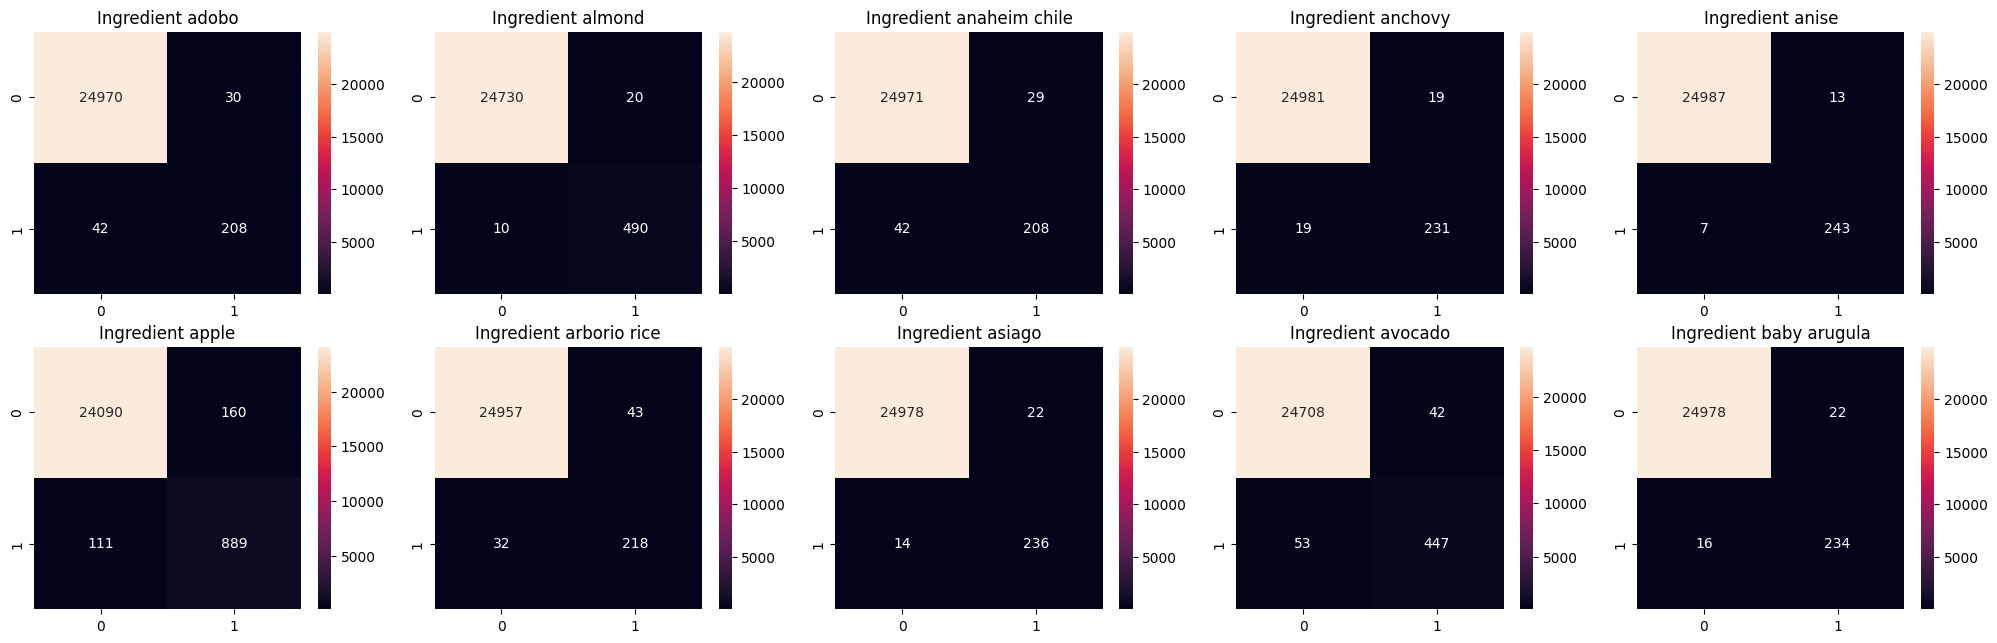

In [34]:
# plot confusion matrix

def plot_confusion_matrix(confusion_matrix):
    fig, ax = plt.subplots(2, 5, figsize=(25, 7.5))

    for i in range(10):
        sns.heatmap(confusion_matrix[i], annot=True, fmt='d', ax=ax[i//5, i%5])
        ax[i//5, i%5].set_title(f'Ingredient {idx_to_ingredient[i]}')

    plt.show()

plot_confusion_matrix(confusion_matrix)

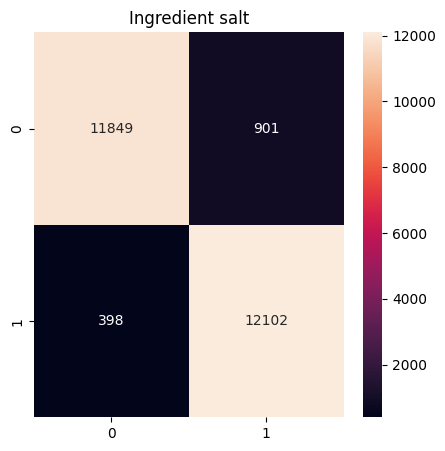

ingredient = 'salt' | accuracy = 0.949 | precision = 0.931 | recall = 0.968 | f1 = 0.949


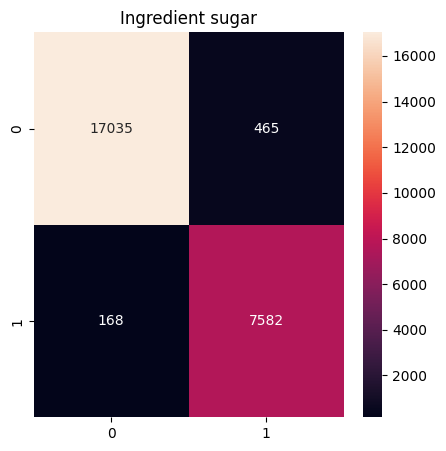

ingredient = 'sugar' | accuracy = 0.975 | precision = 0.942 | recall = 0.978 | f1 = 0.960


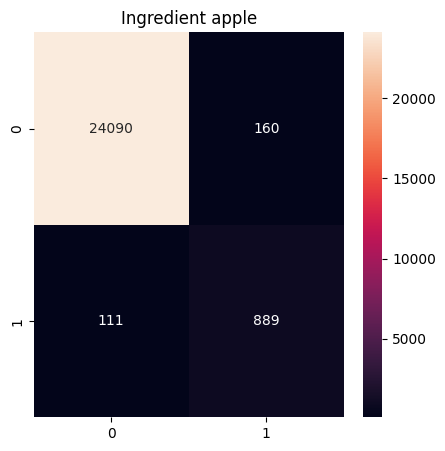

ingredient = 'apple' | accuracy = 0.989 | precision = 0.847 | recall = 0.889 | f1 = 0.868


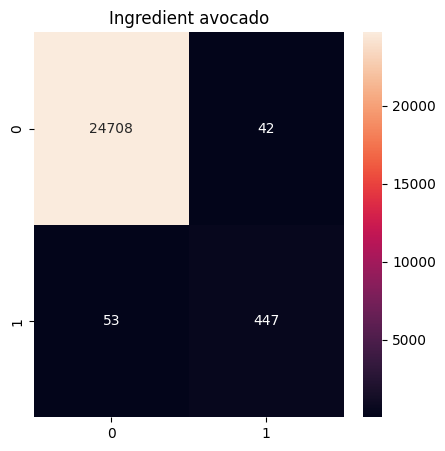

ingredient = 'avocado' | accuracy = 0.996 | precision = 0.914 | recall = 0.894 | f1 = 0.904


In [36]:


# get scores for salt, sugar, apple and avocado

def get_scores(confusion_matrix, ingredient):
    idx = ingredient_to_idx[ingredient]
    tn, fp, fn, tp = confusion_matrix[idx].ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return accuracy, precision, recall, f1 

# plot confusion matrix for salt, sugar, apple and avocado and display scores for each

def plot_ingredient_confusion_matrix(confusion_matrix, ingredient):
    idx = ingredient_to_idx[ingredient]
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    sns.heatmap(confusion_matrix[idx], annot=True, fmt='d', ax=ax)
    ax.set_title(f'Ingredient {ingredient}')
    plt.show()

    accuracy, precision, recall, f1 = get_scores(confusion_matrix, ingredient)
    print(f"{ingredient = } | {accuracy = :.3f} | {precision = :.3f} | {recall = :.3f} | {f1 = :.3f}")

plot_ingredient_confusion_matrix(confusion_matrix, 'salt')
plot_ingredient_confusion_matrix(confusion_matrix, 'sugar')
plot_ingredient_confusion_matrix(confusion_matrix, 'apple')
plot_ingredient_confusion_matrix(confusion_matrix, 'avocado')

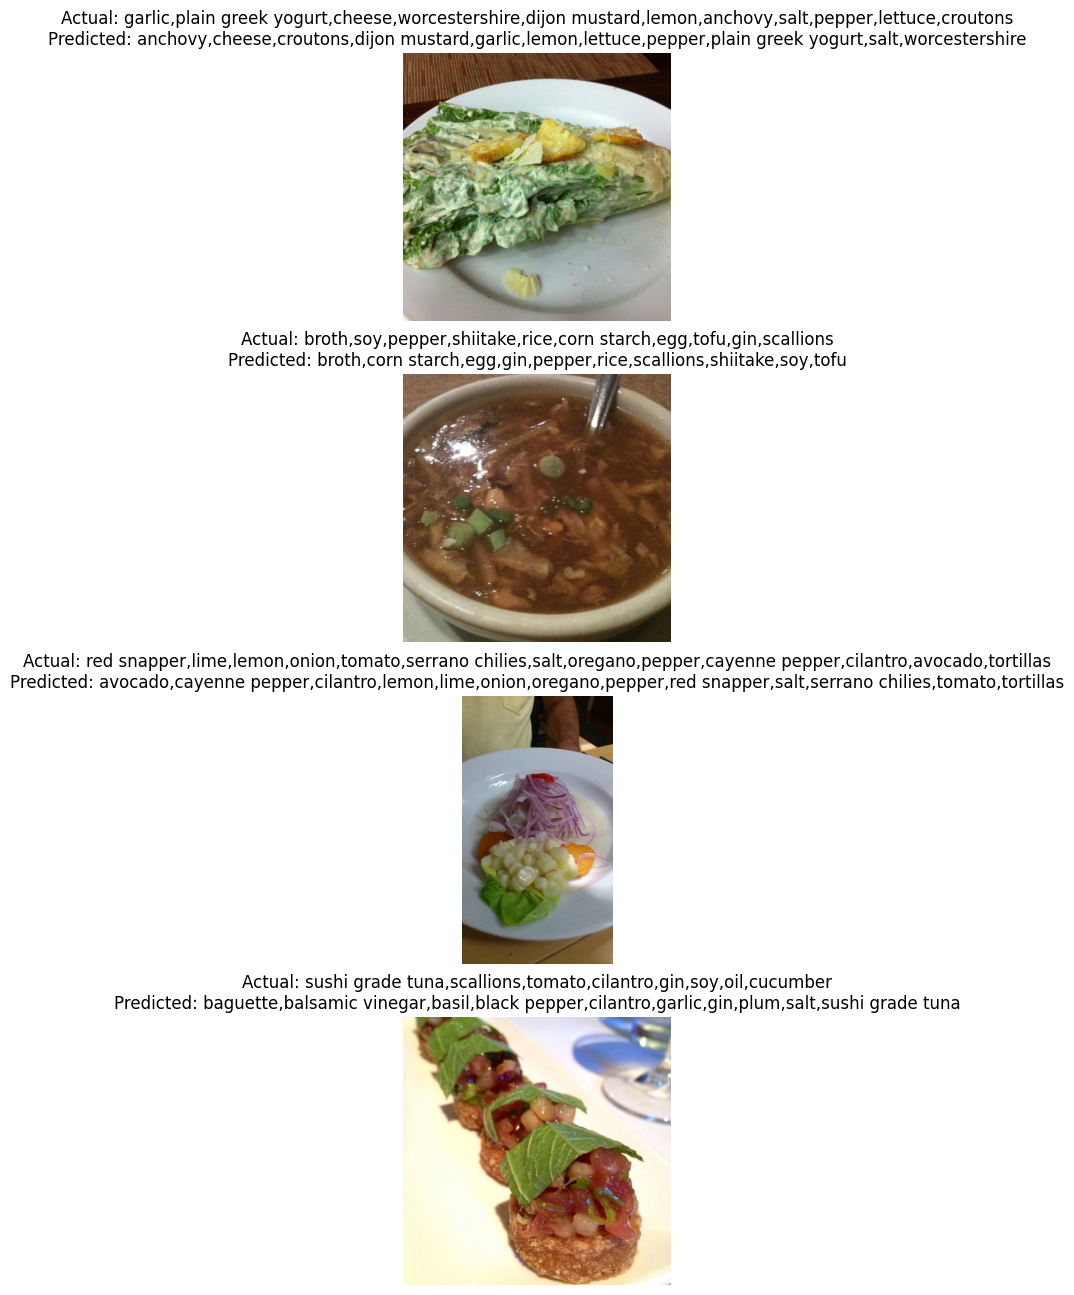

In [40]:
import torch

def show_predictions(rows=2, cols=4):
    model.eval()
    samples = test_dataset.shuffle(seed=4).select(range(rows * cols))
    fig = plt.figure(figsize=(cols * 4, rows * 4))
    
    for i in range(rows * cols):
        img = samples[i]['image']
        labels = samples[i]['labels']
        inputs = samples[i]['pixel_values'].unsqueeze(0).to(device)
        inputs = valid_tfms(img).unsqueeze(0).to(device)
        labels = samples[i]['ingredients']
        
        labels_text = ','.join([idx_to_ingredient[label] for label in labels])
        
        with torch.no_grad():
            logits = model(inputs)
        
        predictions = logits.sigmoid() > threshold  # Anwenden der Sigmoid und Umwandeln in binäre Vorhersagen

        predictions = predictions.cpu().float().numpy().flatten() # convert boolean predictions to float


        pred_labels = np.where(predictions==1)[0] # find indices where prediction is 1
        pred_labels = ','.join([idx_to_ingredient[label] for label in pred_labels]) # converting integer labels to string
        
        # predicted_indices = predictions.nonzero(as_tuple=False).squeeze()  # Finden Sie die Indizes der Vorhersagen, die 1 sind
        # pred_labels_text = ','.join([idx_to_ingredient[label.item()] for label in predicted_indices])
        
        label = f"Actual: {labels_text}\nPredicted: {pred_labels}"
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    
    plt.show()

show_predictions(rows=4, cols=1)


### Evaluation on T_500

The model is also evaluated on a subset of the test set with 500 samples, called T_500. This dataset comprises a minimum of 4 images from each of the 101 food categories, balancing representation while reducing computational requirements. 

In [91]:
# set seed for reproducibility
random.seed(42)

#### Create T_500 subset of the test set

In [92]:
# function to check if an image is valid
def is_valid_image(image_path):
    try:
        with Image.open(image_path) as img:
            if img.format.lower() not in ['png', 'jpeg', 'jpg', 'gif', 'webp']:
                return False
            if os.path.getsize(image_path) > 20 * 1024 * 1024:
                return False
        return True
    except Exception:
        return False

# function to perform stratified sampling
def stratified_sample(data, n):
    # get the number of classes by counting different values in the 'class' column
    classes = {}
    for item in data:
        class_name = item['class']
        if class_name not in classes:
            classes[class_name] = []
        classes[class_name].append(item)

    print(len(classes))

    # calculate the number of samples per class
    num_classes = len(classes)
    samples_per_class = n // num_classes

    # perform stratified sampling with validation
    stratified_sample = []
    class_counts = {}
    for class_name, items in classes.items():
        valid_items = [item for item in items if is_valid_image(item['image'])]
        if len(valid_items) >= samples_per_class:
            selected = random.sample(valid_items, samples_per_class)
            stratified_sample.extend(selected)
            class_counts[class_name] = len(selected)
        else:
            stratified_sample.extend(valid_items)
            class_counts[class_name] = len(valid_items)
    
    # if there aren't enough samples, add more from classes with extra valid samples
    while len(stratified_sample) < n:
        for class_name, items in classes.items():
            if len(stratified_sample) >= n:
                break
            valid_items = [item for item in items if is_valid_image(item['image']) and item not in stratified_sample]
            if valid_items:
                stratified_sample.append(random.choice(valid_items))
                class_counts[class_name] += 1

    return stratified_sample[:n]

In [93]:
def load_data(file_path):
    with open(file_path, 'r') as f:
        return [json.loads(line) for line in f]
    
test_data = load_data('../data/food-ingredients/test.jsonl')
test_data_500 = stratified_sample(test_data, 500)

In [95]:
# check how many images per class are in the test_data_500
classes = {}
for item in test_data_500:
    class_name = item['class']
    if class_name not in classes:
        classes[class_name] = 0
    classes[class_name] += 1

print(classes)

{0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5, 16: 5, 17: 5, 18: 5, 19: 5, 20: 5, 21: 5, 22: 5, 23: 5, 24: 5, 25: 5, 26: 5, 27: 5, 28: 5, 29: 5, 30: 5, 31: 5, 32: 5, 33: 5, 34: 5, 35: 5, 36: 5, 37: 5, 38: 5, 39: 5, 40: 5, 41: 5, 42: 5, 43: 5, 44: 5, 45: 5, 46: 5, 47: 5, 48: 5, 49: 5, 50: 5, 51: 5, 52: 5, 53: 5, 54: 5, 55: 5, 56: 5, 57: 5, 58: 5, 59: 5, 60: 5, 61: 5, 62: 5, 63: 5, 64: 5, 65: 5, 66: 5, 67: 5, 68: 5, 69: 5, 70: 5, 71: 5, 72: 5, 73: 5, 74: 5, 75: 5, 76: 5, 77: 5, 78: 5, 79: 5, 80: 5, 81: 5, 82: 5, 83: 5, 84: 5, 85: 5, 86: 5, 87: 5, 88: 5, 89: 5, 90: 5, 91: 5, 92: 5, 93: 5, 94: 5, 95: 5, 96: 4, 97: 4, 98: 4, 99: 4, 100: 4}


In [96]:
# save stratified sample to file
def save_data(data, file_path):
    with open(file_path, 'w') as f:
        for item in data:
            f.write(json.dumps(item) + '\n')

save_data(test_data_500, '../data/food-ingredients/test_500.jsonl')

{'image': '..\\data\\food-101\\images/apple_pie/3314985.jpg', 'ingredients': [36, 100, 206, 34, 5, 63, 143], 'ingredients_names': ['butter', 'flour', 'sugar', 'brown sugar', 'apple', 'cinnamon', 'nut'], 'class': 0, 'class_name': 'apple_pie'}
{'image': '..\\data\\food-101\\images/apple_pie/1444702.jpg', 'ingredients': [36, 100, 206, 34, 5, 63, 143], 'ingredients_names': ['butter', 'flour', 'sugar', 'brown sugar', 'apple', 'cinnamon', 'nut'], 'class': 0, 'class_name': 'apple_pie'}
{'image': '..\\data\\food-101\\images/apple_pie/1068632.jpg', 'ingredients': [36, 100, 206, 34, 5, 63, 143], 'ingredients_names': ['butter', 'flour', 'sugar', 'brown sugar', 'apple', 'cinnamon', 'nut'], 'class': 0, 'class_name': 'apple_pie'}
{'image': '..\\data\\food-101\\images/apple_pie/3647026.jpg', 'ingredients': [36, 100, 206, 34, 5, 63, 143], 'ingredients_names': ['butter', 'flour', 'sugar', 'brown sugar', 'apple', 'cinnamon', 'nut'], 'class': 0, 'class_name': 'apple_pie'}
{'image': '..\\data\\food-101\\i

#### Evaluate the model on T_500

In [98]:
# load dataset
data_file_500 = {"test": "../data/food-ingredients/test_500.jsonl"}

dataset_500 = datasets.load_dataset('json', data_files=data_file_500)
test_dataset_500 = dataset_500["test"].with_transform(transforms_valid)
test_loader_500 = DataLoader(test_dataset_500, batch_size=32, shuffle=False, collate_fn=collate_fn)

Generating test split: 500 examples [00:00, 62433.82 examples/s]


In [100]:
# run evaluation on 500 samples
def predict_samples_500(model, samples, device, model_name):
    model.eval()
    predictions, actuals = [], []

    for sample in tqdm(samples, desc=f"Predicting for model {model_name}"):
        inputs = sample['pixel_values'].to(device)
        labels = sample['labels'].to(device)
        
        with torch.no_grad():
            logits = model(inputs)
        
        predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
        actuals.append(labels.cpu().numpy())
    
    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)
    
    # calculate metrics
    test_accuracy = multi_label_accuracy(actuals, predictions)
    test_recall_weighted = multi_label_recall(actuals, predictions, average='weighted')
    test_precision_weighted = multi_label_precision(actuals, predictions, average='weighted')
    test_f1_macro = multi_label_f1(actuals, predictions, average='macro')
    test_f1_weighted = multi_label_f1(actuals, predictions, average='weighted')
    test_f1_samples = multi_label_f1(actuals, predictions, average='samples')

    return {
        "test_accuracy": test_accuracy,
        "test_recall_weighted": test_recall_weighted,
        "test_precision_weighted": test_precision_weighted,
        "test_f1_macro": test_f1_macro,
        "test_f1_weighted": test_f1_weighted,
        "test_f1_samples": test_f1_samples
    }

In [101]:
# define, which models to evaluate
models = ['swin_s3_small_224', 'deit3_medium_patch16_224', 'volo_d3_224', 'vit_base_patch16_224', 'vit_base_patch32_clip_224']

def evaluate_samples_500(models, samples):
    results = {}

    for model_name in models:
        model = create_model(model_name, pretrained=True, num_classes=num_unique_ingredients)
        state_dict = torch.load(f"./models/{model_name}-pascal-epoch-14.pth")
        model.load_state_dict(state_dict)
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        
        results[model_name] = predict_samples_500(model, samples, device, model_name)

    return results

results = evaluate_samples_500(models, test_loader_500)

Predicting for model vit_base_patch32_clip_224: 100%|██████████| 16/16 [00:02<00:00,  7.53it/s]


In [102]:
table = PrettyTable()
table.field_names = ["Model", "Accuracy", "Recall (weighted)", "Precision (weighted)", "F1 (macro)", "F1 (weighted)", "F1 (samples)"]
    
for model_name, result in results.items():
    accuracy = round(result["test_accuracy"], 4)
    recall_weighted = round(result["test_recall_weighted"], 4)
    precision_weighted = round(result["test_precision_weighted"], 4)
    f1_macro = round(result["test_f1_macro"], 4)
    f1_weighted = round(result["test_f1_weighted"], 4)
    f1_samples = round(result["test_f1_samples"], 4)

    table.add_row([model_name, accuracy, recall_weighted, precision_weighted, f1_macro, f1_weighted, f1_samples])
print(table)

+---------------------------+----------+-------------------+----------------------+------------+---------------+--------------+
|           Model           | Accuracy | Recall (weighted) | Precision (weighted) | F1 (macro) | F1 (weighted) | F1 (samples) |
+---------------------------+----------+-------------------+----------------------+------------+---------------+--------------+
|     swin_s3_small_224     |  0.9936  |       0.9323      |        0.9066        |   0.9076   |     0.9173    |    0.913     |
|  deit3_medium_patch16_224 |  0.9909  |       0.9017      |        0.8697        |   0.8721   |     0.8828    |    0.8741    |
|        volo_d3_224        |  0.9926  |       0.9121      |        0.9007        |   0.8941   |     0.9041    |    0.9018    |
|    vit_base_patch16_224   |  0.9892  |       0.8805      |        0.8494        |   0.853    |     0.8611    |    0.8525    |
| vit_base_patch32_clip_224 |  0.9689  |       0.6539      |        0.5815        |   0.5527   |     0.6

## Sources

[1] Han, J. (2021). Identification of Ingredient in Pictures of Food with Deep Learning [Masterarbeit]. Hochschule für Technik und Wirtschaft Berlin.

[2] Gao, X., Xiao, Z., & Deng, Z. (2024). High accuracy food image classification via vision transformer with data augmentation and feature augmentation. Journal of Food Engineering, 365, 111833. https://doi.org/10.1016/j.jfoodeng.2023.111833